<a href="https://colab.research.google.com/github/rsethi21/dynamicModellingPI3K-Akt/blob/main/Goodwin_Oscillation_PI3K_AKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pathway

## Resources:
Resource Inspiring Investigation: https://www.pnas.org/doi/10.1073/pnas.1501441112
Pathway mathematical terms = http://mcb111.org/w11/w11-lecture.html, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5355565/
Pathway examples = https://www.hindawi.com/journals/jam/2018/2983138/, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152104

## Code

### Imports

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from scipy.integrate import odeint

### Notes

In [ ]:
## NOTES:

  # Completed Tasks:
    # add term for relationship between pAkt and a microglial state which is fit by Emily's data conditions (phagacytosis assay) [+]
    # generate plots for one set of conditions, each has a steady state and then add the modifier (constitutive PI3K or agonist) [+]
      # TREM2 is upstream of PI3K; treatment with ATP [+]
      # LPS [+]
      # Y294 [+]
    # steady state is "starting point" relative [+]
    # M2 polarization box based on phosphorylation of Akt [+]
    # add time argument to the applied conditions such that the stimuli can be adjusted to run on at certain times/overlapping times [+]

  # TODO:
     # research what has been measured experimentally from an M2 state (pH; PIP3 production (doesn't invovle western blotting to get more time dependent information))
     # create a progress bar
     # Validate using Wang paper (create bar plot for pAkt and pPTEN) for each condition (to apply more accurate rate constants; maybe automate, we'll see)
     # investigate effects of ROS and other states on conditions
     
     # Backburner:
        # maybe create software that would allow for streamlined assembly of the kinetics of different biochemical pathways
        # Can I make a machine learning algorithm that checks what the best parameters are

  # Publish:
    # goldwater
    # publish finalized computational stuff
    # biophysical society meeting
    # local conferences
      # midwest enzymes conference

### Main Rate Function

In [125]:
## function for ordinary differential equations:

def func(y,t, Lps=(False, None, None, None), Trem2=(False, None, None, None), y294=(False, None, None, None)): # when integrating pass in boolean arguments for any combination of modifications supported
  pAkt, PTEN, PIP3, pPI3K, M2, LPS, TREM2, Y294 = y

## rate constants:

  k1 = 1
  k2 = 1
  k3 = 1.5
  k4 = 0.1
  k5 = 1
  k6 = 0.1
  k7 = 1
  k8 = 0.1
  K1 = 1
  K2 = 1
  K3 = 1
  K4 = 1
  n1 = 5 # disclose that net effect is that it is representative of the actual system
  n3 = 2
  k9 = 1 # M2 activation max
  k10 = 0.1 # background processes opposing M2
  Km = 2
  # separate becuase assume have their own kinetics
  d1 = .1
  d2 = .1
  d3 = .1

## Differential Equations: ask which one is more accurate
  
  if y294[0] == True and Trem2[0] == False:
    dpPI3Kdt = k1 - k2*pPI3K - d1*Y294 # inhibitor
  elif y294[0] == False and Trem2[0] == True:
    dpPI3Kdt = k1 - k2*pPI3K + d2*TREM2 # upstream agonist
  elif y294[0] == True and Trem2[0] == True:
    dpPI3Kdt = k1 - k2*pPI3K - d1*Y294 + d2*TREM2 # upstream agonist and inhibitor
  else:
    dpPI3Kdt = k1 - k2*pPI3K # constituitive

  dPIP3dt = k3*((K1**n1)/(K1**n1 + PTEN**n1))*pPI3K - k4*PIP3 # goodwin oscillator for classical deactivation

  dpAktdt = k5*(((PIP3)/(K3 + PIP3))**n3) - k6*pAkt # requires two binding sites for maximal activation

  if Lps[0] == True:
    dPTENdt = k7*(pAkt/(K4+pAkt)) - k8*PTEN + d3*LPS # upstream agonist
  else:
    dPTENdt = k7*(pAkt/(K4+pAkt)) - k8*PTEN # added this to improve delay between pAkt and PTEN because its not immediate

  dM2dt = (k9*pAkt)/(pAkt + Km) - M2*k10 # to force a maximum or at least some roofing
  
  dLpsdt = 0
  dTREM2dt = 0
  dY294dt = 0

  if Lps[0] == True:
    if t < Lps[1]:
      dLpsdt = 0
    elif t >= Lps[1] and t <= Lps[2]:
      dLpsdt = Lps[3] - LPS
    elif t > Lps[2]:
      dLpsdt = -LPS

  if Trem2[0] == True:
    if t < Trem2[1]:
      dTREM2dt = 0
    elif t >= Trem2[1] and t <= Trem2[2]:
      dTREM2dt = Trem2[3] - TREM2
    elif t > Trem2[2]:
      dTREM2dt = -TREM2

  if y294[0] == True:
    if t < y294[1]:
      dY294dt = 0
    elif t >= y294[1] and t <= y294[2]:
      dY294dt = y294[3] - Y294
    elif t > y294[2]:
      dY294dt = -Y294

  ## other possibilties to consider

  # dpPI3Kdt = k1 - k2*pPI3K
  # dPIP3dt = k3*((K1**n1)/(K1**n1 + PTEN**n1))*pPI3K - k4*PIP3
  # dpAktdt = k5*(((PIP3)/(K3 + PIP3))**n3) - k6*pAkt
  # dPTENdt = k7*pAkt - k8*PTEN

  # dpPI3Kdt = k1 - k2*pPI3K
  # dPIP3dt = k3*((K1**n1)/(K1**n1 + PTEN**n1))*(((pPI3K)/(K2 + pPI3K))**n3) - k4*PIP3
  # dpAktdt = k5*(((PIP3)/(K3 + PIP3))**n3) - k6*pAkt
  # dPTENdt = k7*(((pAkt)/(K4 + pAkt))**n3) - k8*PTEN

  # dpPI3Kdt = k1 - k2*pPI3K
  # dPIP3dt = k3*((K1**n1)/(K1**n1 + PTEN**n1)) + k3*(((pPI3K)/(K2 + pPI3K))**n3) - k4*PIP3
  # dpAktdt = k5*(((PIP3)/(K3 + PIP3))**n3) - k6*pAkt
  # dPTENdt = k7*(((pAkt)/(K4 + pAkt))**n3) - k8*PTEN

  dydt = [dpAktdt, dPTENdt, dPIP3dt, dpPI3Kdt, dM2dt, dLpsdt, dTREM2dt, dY294dt]
  return dydt

### Can use to determine steady state

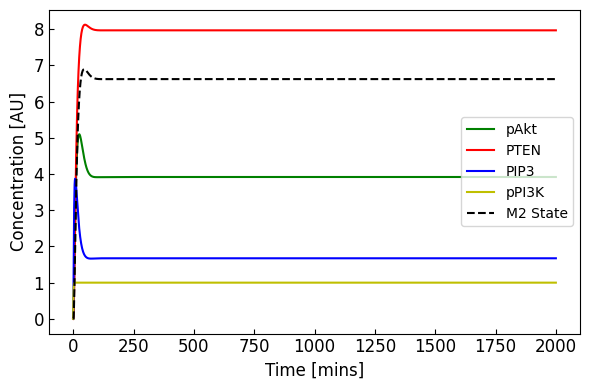

In [126]:
## Graphing values:

time = np.linspace(0,2000, 2000)
y0 = [0, 0, 0, 0, 0, 0, 0, 0]
y_steady = odeint(func,y0,time)

## Plotting

plt.figure(figsize=(6,4),dpi=100)
# plt.ylim(0.858, .862)
plt.plot(time,y_steady[:,0],'g-',label='pAkt')
plt.plot(time,y_steady[:,1],'r-',label='PTEN')
plt.plot(time,y_steady[:,2],'b-',label='PIP3')
plt.plot(time,y_steady[:,3],'y-',label='pPI3K')
plt.plot(time,y_steady[:,4],'k--',label='M2 State')
plt.tick_params(direction='in',labelsize=12)
plt.xlabel('Time [mins]',fontsize=12)
plt.ylabel('Concentration [AU]',fontsize=12)
plt.legend(loc='best',fontsize=10)
plt.tight_layout()

In [127]:
## averaging

steadyState = sum(y_steady[1750:2001])/250
print(steadyState)

[3.91723164 7.96633538 1.67292426 1.         6.62004105 0.
 0.         0.        ]


### LPS activation result

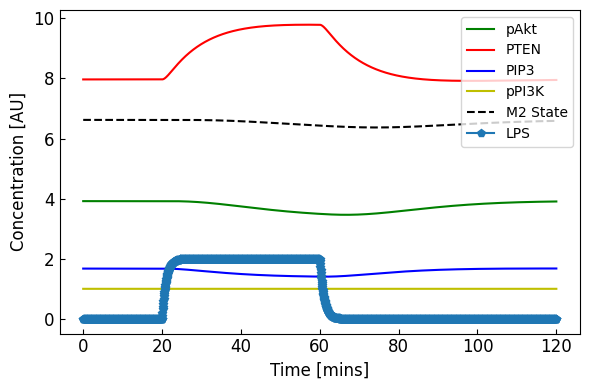

In [128]:
## Graphing values:

time = np.linspace(0,120, 2000)
y0_2 = [steadyState[0], steadyState[1], steadyState[2], steadyState[3], steadyState[4], 0, 0, 0]
y_2 = odeint(func,y0_2,time,((True, 20, 60, 2), (False,  None, None), (False, None, None)))

## Plotting

plt.figure(figsize=(6,4),dpi=100)
# plt.ylim(0.858, .862)
plt.plot(time,y_2[:,0],'g-',label='pAkt')
plt.plot(time,y_2[:,1],'r-',label='PTEN')
plt.plot(time,y_2[:,2],'b-',label='PIP3')
plt.plot(time,y_2[:,3],'y-',label='pPI3K')
plt.plot(time,y_2[:,4],'k--',label='M2 State')
plt.plot(time,y_2[:,5],'p-',label='LPS')
plt.tick_params(direction='in',labelsize=12)
plt.xlabel('Time [mins]',fontsize=12)
plt.ylabel('Concentration [AU]',fontsize=12)
plt.legend(loc='best',fontsize=10)
plt.tight_layout()

### TREM2 Activation of PI3K

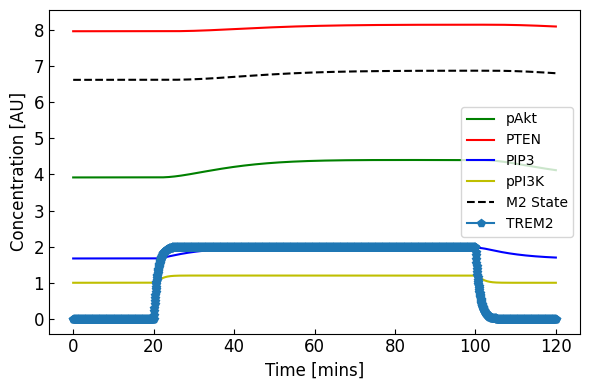

In [129]:
## Graphing values:

time = np.linspace(0,120, 2000)
y0_3 = [steadyState[0], steadyState[1], steadyState[2], steadyState[3], steadyState[4], 0, 0, 0]
y_3 = odeint(func,y0_3,time, ((False, None, None, None), (True, 20, 100, 2), (False, None, None, None)))

## Plotting

plt.figure(figsize=(6,4),dpi=100)
# plt.ylim(0.858, .862)
plt.plot(time,y_3[:,0],'g-',label='pAkt')
plt.plot(time,y_3[:,1],'r-',label='PTEN')
plt.plot(time,y_3[:,2],'b-',label='PIP3')
plt.plot(time,y_3[:,3],'y-',label='pPI3K')
plt.plot(time,y_3[:,4],'k--',label='M2 State')
plt.plot(time,y_3[:,6],'p-',label='TREM2')
plt.tick_params(direction='in',labelsize=12)
plt.xlabel('Time [mins]',fontsize=12)
plt.ylabel('Concentration [AU]',fontsize=12)
plt.legend(loc='best',fontsize=10)
plt.tight_layout()

### Extra Useful Scripts

In [ ]:
## Finding Max Values in a certain time range

max_time = None
maxValue = -1
for i, arr in enumerate(y):
  time = (i/float(750))*50
  if arr[0] >= maxValue:
    maxValue = arr[0]
    max_time = time
print(max_time)

array([1.59913221, 2.42619142, 0.6669133 , 1.005     , 4.45297544])

In [ ]:
## averaging in a certain time range

sum(y[600:801])/200